#N-Grams

In [37]:
%pylab inline
import rlcompleter, readline
readline.parse_and_bind('tab: complete')

Populating the interactive namespace from numpy and matplotlib


In [51]:
import csv
train_label = np.genfromtxt('label.txt')
test_label = np.asarray([1]*300+[0]*300)
train_dic = []
test_dic = []
with open('train_dic.txt','r') as f:
    reader = csv.reader(f)
    for line in reader:
        train_dic.append(line)
with open('test_dic.txt','r') as f:
    reader = csv.reader(f)
    for line in reader:
        test_dic.append(line)

#Build up n-gram dictionary

In [121]:
#build up n-gram dictionary
def ngrams(data, N):
    ngrams = []
    for line in data:
        ngrams.append([line[i:i+N] for i in range(len(line)-(N-1))])
    return ngrams
ngrams_train = ngrams(train_dic,2)
def buildDic(data,N):
    uniq = []
    ngrams = []
    for line in data:
        ngrams.extend([line[i:i+N] for i in range(len(line)-(N-1))])
    for each in ngrams:
        if each not in uniq:
            uniq.append(each)
    return uniq

In [123]:
dic = buildDic(train_dic,2)
print len(dic)

11912


In [127]:
#build up feature vector
def build_vector(train):
    vectors = []
    for line in train:
        vector = [0]*len(dic)
        for grams in line:
            if grams in dic:
                vector[dic.index(grams)] += 1
        vectors.append(vector)
    return np.asarray(vectors)

In [128]:
train_vectors = build_vector(ngrams(train_dic,2))
test_vectors = build_vector(ngrams(test_dic,2))

In [145]:
#clean test and training set
# there are samples in testing set that doesn't contain any words in dictionary
#which means the feature_vectors are empty.
index = [i for i in range(test_vectors.shape[0]) if np.sum(test_vectors[i]) == 0]
clean_test_vectors = np.delete(test_vectors,index,0)
clean_test_label = np.delete(test_label,index,0)
clean_test_vectors.shape,clean_test_label.shape
#after cleaning, 255 testing sample remain

# there are samples in training set that doesn't contain any words in dictionary
#which means the feature_vectors are empty.
index = [i for i in range(train_vectors.shape[0]) if np.sum(train_vectors[i]) == 0]
clean_train_vectors = np.delete(train_vectors,index,0)
clean_train_label = np.delete(train_label,index,0)
clean_train_vectors.shape,clean_train_label.shape
#after cleaning, 2319 testing sample remain

((2319, 11912), (2319,))

In [133]:
#normalize the data
def normalization(train):
    train = np.asarray(train)
    s_train = []
    for i in range(train.shape[0]):
        s_train.append(train[i]/np.sqrt(np.sum((train[i])**2)))
    return np.asarray(s_train)

In [148]:
normalize_train = normalization(clean_train_vectors)
normalize_test = normalization(clean_test_vectors)

#K-MEANS

In [153]:
# k-means implementation
from scipy.spatial import distance
def k_means(train,threshold):
    #initial centroid
    new_m1 = train[np.random.randint(len(train))]
    new_m2 = train[np.random.randint(len(train))]
    diff = 1000
#keep interation until the different between new centroid and old centriod go under the treshold
    while(diff > threshold):
        c1, c2= [],[]
        c1_label,c2_label = [],[]
        m1,m2 = new_m1,new_m2
        print np.sum(m1),np.sum(m2)
        for i,line in enumerate(train):
#            print np.sum(line)
            dis1 = np.sqrt(sum((line - m1) ** 2))
            dis2 = np.sqrt(sum((line - m2) ** 2))
#            print "dis:",dis1,dis2
            #assign each sample to nearest centroid
            if(dis1 > dis2):
                c2.append(line)
                c2_label.append(train_label[i]);
            if(dis1 < dis2):
                c1.append(line)
                c1_label.append(train_label[i]);
            if(dis1 == dis2):
                x = np.random.randint(2);
                if(x == 0):
                    c1.append(line)
                    c1_label.append(train_label[i]);
                if(x == 1):
                    c2.append(line) 
                    c2_label.append(train_label[i]);
        #adjust centroid
        new_m1 = np.mean(np.asarray(c1),axis = 0)
        new_m2 = np.mean(np.asarray(c2),axis = 0)
        print "new",np.sum(new_m1),np.sum(new_m2)
        #compute the difference between new centroids and old centroids
        diff = (np.sqrt(sum((new_m1 - m1) ** 2)) + np.sqrt(sum((new_m2 - m2) ** 2)))/2
        print "diff",diff
    return new_m1,new_m2,c1,c2,c1_label,c2_label  

In [154]:
m1,m2,c1,c2,c1_label,c2_label = k_means(normalize_train,0.5)

2.2360679775 3.0
new 2.17892580489 2.26811036139
diff 0.999535393875
2.17892580489 2.26811036139
new 2.17913614735 2.26767269483
diff 0.00762799250993


In [155]:
len(c1)

1291

#Evaluation

In [149]:
def vote(c):
    count0 = len([i for i in c if i == 0.0])
    count1 = len([i for i in c if i == 1.0])
#    print count0,count1
    if(count0 > count1):
        return 0.0
    else:
        return 1.0


In [157]:
vote_c1 =vote(c1_label)
vote_c2 = vote(c2_label)

In [158]:
#evaluate performance of k-menas
def evaluation(c1_label,vote_c1,c2_label,vote_c2):
    ratio1 = len([i for i in c1_label if i == vote_c1])/float(len(c1_label))
    ratio2 = len([i for i in c2_label if i == vote_c2])/float(len(c2_label))
    print "cluster 1 score:",ratio1,"cluster2 score:",ratio2
    ratio = (len([i for i in c1_label if i == vote_c1])+len([i for i in c2_label if i == vote_c2]))/float((len(c1_label)+len(c2_label)))
    return ratio


In [159]:
evaluation(c1_label,vote_c1,c2_label,vote_c2)

cluster 1 score: 0.545313710302 cluster2 score: 0.596303501946


0.5679172056921087

#Sentiment Prediction

0.729411764706
[[91 36]
 [33 95]]


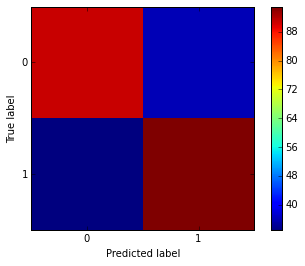

In [160]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(normalize_train,clean_train_label)
#report accuracy of logistic regression
pred = clf.predict(normalize_test)
accuracy = clf.score(normalize_test,clean_test_label)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(clean_test_label,pred)
plt.imshow(cm, interpolation='nearest')
plt.colorbar()
tick_marks = np.array([0,1])
plt.xticks(tick_marks, [0,1])
plt.yticks(tick_marks, [0,1])
plt.ylabel('True label')
plt.xlabel('Predicted label')
print accuracy
print cm

In [172]:
maxs = sorted(clf.coef_[0])[len(clf.coef_)-21:]
#print max_5
keywords = []
for each in maxs:
    index = [i for i in range(clf.coef_.shape[1]) if clf.coef_[0][i] == each]
    keywords.append(dic[index[0]])
print keywords

[['well', 'made'], ['great', 'film'], ['film', 'great'], ['definitely', 'worth'], ['highly', 'recommended'], ['love', 'phone'], ['great', 'price'], ['pretty', 'good'], ['great', 'deal'], ['good', 'product'], ['excellent', 'product'], ['good', 'price'], ['good', 'quality'], ['easy', 'use'], ['great', 'product'], ['work', 'fine'], ['highly', 'recommend'], ['one', 'best'], ['great', 'phone'], ['work', 'great']]
